 ### Estime the inital condition using PINNs (inverse problem). 
The goal of the inverse problem is to estimate the inital pressure field $p_\text{ini}(x,y) = p(x,y,0)$ that satisfies the wave equation,
$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = 0.$$

The inference of $p_\text{ini}(x,y)$ will be based on:
- Observed data 
- Physics via the undelying PDE

We will use physics-informed neural networks (PINNs) for the task of estimating $p_\text{ini}(x,y)$.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from PINNs_util.PINNs_fdiff import solver
from PINNs_util.PINNs_aux import FCN,\
                        xyt_tensor,\
                        pde_residual,\
                        update_lambda,\
                        absorbing_boundary,\
                        rand_colloc,\
                        rand_bound
from PINNs_util.PINNs_plots import plot_train_log_bound,\
                        plot_train_log,\
                        plot_field,\
                        plot_data,\
                        plot_inital_estimation,\
                        plot_estimation

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Problem setup
As in the notebook 'PINNs_forward', we define a 2+1D domain. We consider a somewhat more complex initial condition, composed of two Gaussian pulses with different width in $x$ and $y$.

In [2]:
# define domain
L = 5
T = 2
c = 3

# scaling
T = T*c/L
L = L/L
c = 1

# simulation
Lx, Ly = L, L
Nx, Ny = 100, 100
dt = -1

# initial condition
def I(x, y):
    gpulse_std_x = 5e-2
    gpulse_std_y = 10e-2
    r_source = np.array([0.3, 0.3])
    I = np.exp(-0.5*( ((x-r_source[0])/gpulse_std_x)**2 +\
                      ((y-r_source[1])/gpulse_std_y)**2 ))
    r_source = np.array([0.5, 0.6])
    I = I - np.exp(-0.5*( ((x-r_source[0])/gpulse_std_x)**2 +\
                      ((y-r_source[1])/gpulse_std_y)**2 ))
    return I

# solve
p_ref, x, y, t, dt = solver(I, 0, 0, c, Lx, Ly, Nx, Ny, dt, T)
p_ref, x, y, t = p_ref.astype(np.float32), x.astype(np.float32), y.astype(np.float32), t.astype(np.float32)

# we need tensors
xx, yy = np.meshgrid(x, y)
xy = np.column_stack((np.reshape(xx,(-1,1)), np.reshape(yy,(-1,1))))
r_ref = xyt_tensor(xy, t, device)
n_T = t.shape[0]
n_L = x.shape[0]

# plot reference field (it might take a few seconds)
# ani = plot_field(p_ref, L, 'reference pressure')
# ani

  0%|          | 0/169 [00:00<?, ?it/s]

100%|██████████| 169/169 [00:00<00:00, 4006.47it/s]


### Generate data
We now define the observed data used for estimating the field. The data will be `n_data` points randomly dsitributed over the domain (black triangles in the left figure). The observed data, called `p_data`, is shown in the rigth figure.

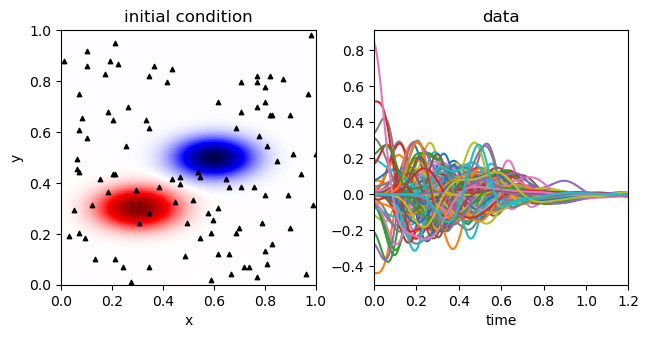

In [3]:
n_data = 100
i_data = np.random.choice(n_L**2, n_data, replace=False)

x_data = xx.reshape(-1,1)[i_data]
y_data = yy.reshape(-1,1)[i_data]
xy_data = np.column_stack((x_data, y_data))
r_data = xyt_tensor(xy_data, t, device)
p_data = p_ref.reshape(-1,n_T)[i_data,:]

# Plot data
plot_data(p_ref, p_data, x_data, y_data, L, T)

p_data = torch.tensor(p_data, device=device)

# Initial condition
t_ini = t[0:1]
r_ini = xyt_tensor(xy, t_ini, device)
p_ini = p_ref[:,:,0:2].reshape(-1,2)
p_ini = torch.tensor(p_ini, device=device)

### PINNs
 We define two NNs, `model_p` with inputs $(x,y,t)$ will learn the pressure field $p(x,y,t)$, and `model_p0` with inputs $(x,y)$ will learn inital pressure $p_\text{ini}(x,y)$. The number of layers, hidden units, etc. do not need to be the same for the two NNs (`model_p0` could actually be smaller as the function $p_\text{ini}(x,y)$ is not as complex as $p(x,y,t)$).

In [4]:
n_in = 3
n_out = 1
n_ffeatures = 64
n_hidden = 64
n_layers = 3
n_lamb_update = 100
n_colloc = int(1e4)
n_bound = int(1e3)
n_epochs = int(3e1)
lamb = [1, 1, 1, 1]

model_p = FCN(n_in, n_out, n_ffeatures, n_hidden, n_layers)
model_p = model_p.to(device)
model_p0 = FCN(n_in-1, n_out, n_ffeatures, n_hidden, n_layers)
model_p0 = model_p0.to(device)

optimiser_p = torch.optim.Adam(model_p.parameters(), lr=1e-4)
optimiser_p0 = torch.optim.Adam(model_p0.parameters(), lr=1e-4)
mse_loss = nn.MSELoss()

loss_data_p_hist = []
loss_data_p0_hist = []
loss_pde_hist = []
loss_ini_hist = []
loss_bound_hist = []
lamb_data_p_hist = []
lamb_data_p0_hist = []
lamb_pde_hist = []
lamb_ini_hist = []
lamb_bound_hist = []

In [5]:
for i in tqdm(range(n_epochs)):
    optimiser_p.zero_grad()
    optimiser_p0.zero_grad()

    # initial condition loss (both NN)
    p0 = model_p0(r_ini[:,0:2])
    p = model_p(r_ini)
    loss_ini = mse_loss(p0, p)

    # data loss (for model_p0)
    p = model_p0(r_data[:,0:2])
    p = p.reshape(-1, n_T)
    loss_data_p0 = mse_loss(p[:,0], p_data[:,0])

    # data loss (for model_p)
    p = model_p(r_data)
    p = p.reshape(-1, n_T)
    loss_data_p = mse_loss(p, p_data)

    # pde loss (for model_p)
    r_colloc = rand_colloc(n_colloc, L, T, device)
    p = model_p(r_colloc)
    pde_res = pde_residual(p, r_colloc, c)
    loss_pde = mse_loss(pde_res, torch.zeros_like(p))

    loss_lst = [loss_data_p, loss_data_p0, loss_pde, loss_ini]

    # get gradients and update lambda
    if i % n_lamb_update == 0: 
        lamb = update_lambda(model_p, loss_lst, lamb, 0.9)

    # total loss
    loss = loss_data_p +\
            loss_data_p0*lamb[1]/lamb[0] +\
            loss_pde*lamb[2]/lamb[0] +\
            loss_ini*lamb[3]/lamb[0] 

    # backpropagate
    loss.backward()
    optimiser_p.step()
    optimiser_p0.step()

    # log
    loss_data_p_hist.append(loss_data_p.item())
    loss_data_p0_hist.append(loss_data_p0.item())
    loss_pde_hist.append(loss_pde.item())
    loss_ini_hist.append(loss_ini.item())

    lamb_data_p_hist.append(lamb[0].item())
    lamb_data_p0_hist.append(lamb[1].item())
    lamb_pde_hist.append(lamb[2].item())
    lamb_ini_hist.append(lamb[3].item())

    # print loss
    if i % 1000 == 999:
        print('[%5d] loss: %.3f*1e-3' %
        (i + 1, loss.item()*1e3))

  0%|          | 0/30 [00:00<?, ?it/s]/home/samuel/anaconda3/envs/ao-pinns-env/lib/python3.12/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 30/30 [00:00<00:00, 31.63it/s]


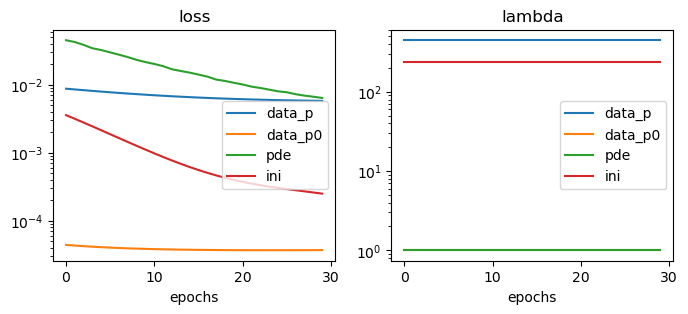

In [6]:
loss = [loss_data_p_hist, loss_data_p0_hist, loss_pde_hist, loss_ini_hist]
lamb = [lamb_data_p_hist, lamb_data_p0_hist, lamb_pde_hist, lamb_ini_hist]
label = ["data_p", "data_p0", "pde", "ini"]
plot_train_log(loss, lamb, label)

In [7]:
# Plot reference and estimation
p_est = model_p(r_ref)
p_est = np.reshape(p_est.cpu().detach().numpy(), (-1, n_T))
ani = plot_estimation(p_ref, p_est, L)
ani